# IF3270 Machine Learning | Praktikum

This notebook serves as a template for the assignment. Please create a copy of this notebook to complete your work. You can add more code blocks, markdown blocks, or new sections if needed.


Group Number: xx

Group Members:
- Name (NIM)
- Name (NIM)

## Import Libraries

In [531]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier, 
    VotingClassifier, 
    StackingClassifier
)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import warnings
warnings.filterwarnings('ignore')

## Import Dataset

In [532]:
# Train
url = "Train_processed.csv"
# Test
url_test = "test_processed_no_solution.csv"

train_df = pd.read_csv(url)
test_df = pd.read_csv(url_test)

print("Training data shape:", train_df.shape)
print("Test data shape:", test_df.shape)

Training data shape: (5647, 11)
Test data shape: (2421, 10)


# 1. Exploratory Data Analysis

Exploratory Data Analysis (EDA) is a crucial step in the data analysis process that involves examining and visualizing data sets to uncover patterns, trends, anomalies, and insights. It is the first step before applying more advanced statistical and machine learning techniques. EDA helps you to gain a deep understanding of the data you are working with, allowing you to make informed decisions and formulate hypotheses for further analysis. Provide at least 3 analysis

#### Null Value

In [533]:
print("Null value")
train_df.isnull().sum()

Null value


ID                   0
Gender               0
Ever_Married        84
Age                  0
Graduated           40
Profession          79
Work_Experience    562
Spending_Score       0
Family_Size        224
Var_1               53
Segmentation         0
dtype: int64

#### Described Data

In [534]:
train_df.describe()

,ID,Age,Work_Experience,Family_Size
count,5647.000000,5647.000000,5085.000000,5423.000000
mean,463474.687799,43.663538,2.654277,2.861147
std,2598.820204,16.779417,3.429239,1.536501
min,458982.000000,16.000000,0.000000,1.000000
25%,461248.500000,30.000000,0.000000,2.000000
50%,463468.000000,41.000000,1.000000,3.000000
75%,465754.500000,53.000000,4.000000,4.000000
max,467974.000000,91.000000,14.000000,9.000000


#### Distribusi Segmen

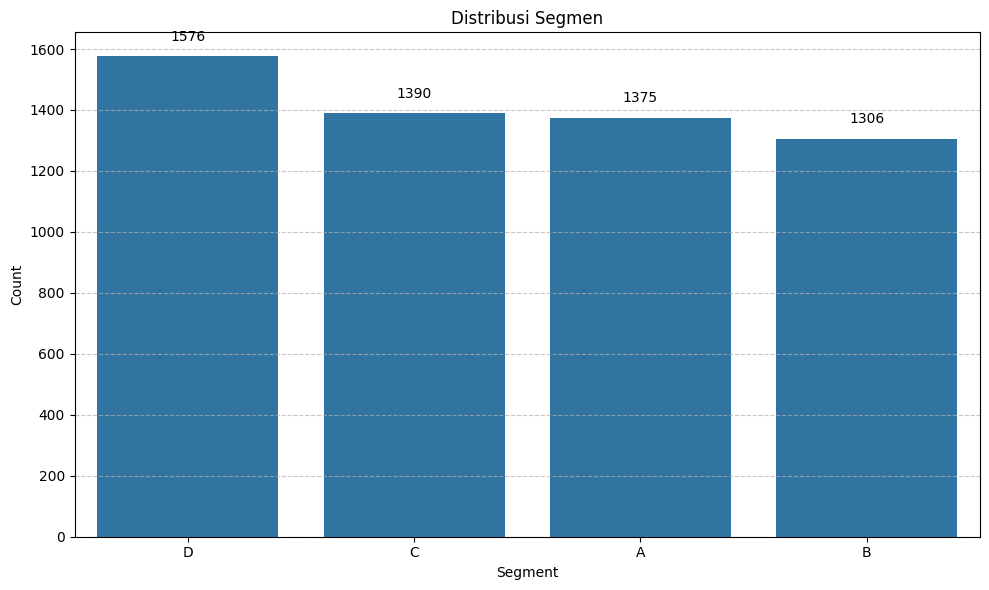

Persentase Distribusi Segmen:
Segmen D: 27.91%
Segmen C: 24.61%
Segmen A: 24.35%
Segmen B: 23.13%


In [535]:
plt.figure(figsize=(10, 6))
segment_counts = train_df['Segmentation'].value_counts()
sns.barplot(x=segment_counts.index, y=segment_counts.values)
plt.title('Distribusi Segmen')
plt.xlabel('Segment')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i, count in enumerate(segment_counts.values):
    plt.text(i, count + 50, str(count), ha='center')

plt.tight_layout()
plt.show()

print("Persentase Distribusi Segmen:")
segment_percentage = segment_counts / len(train_df) * 100
for segment, percentage in segment_percentage.items():
    print(f"Segmen {segment}: {percentage:.2f}%")

#### Matriks Korelasi

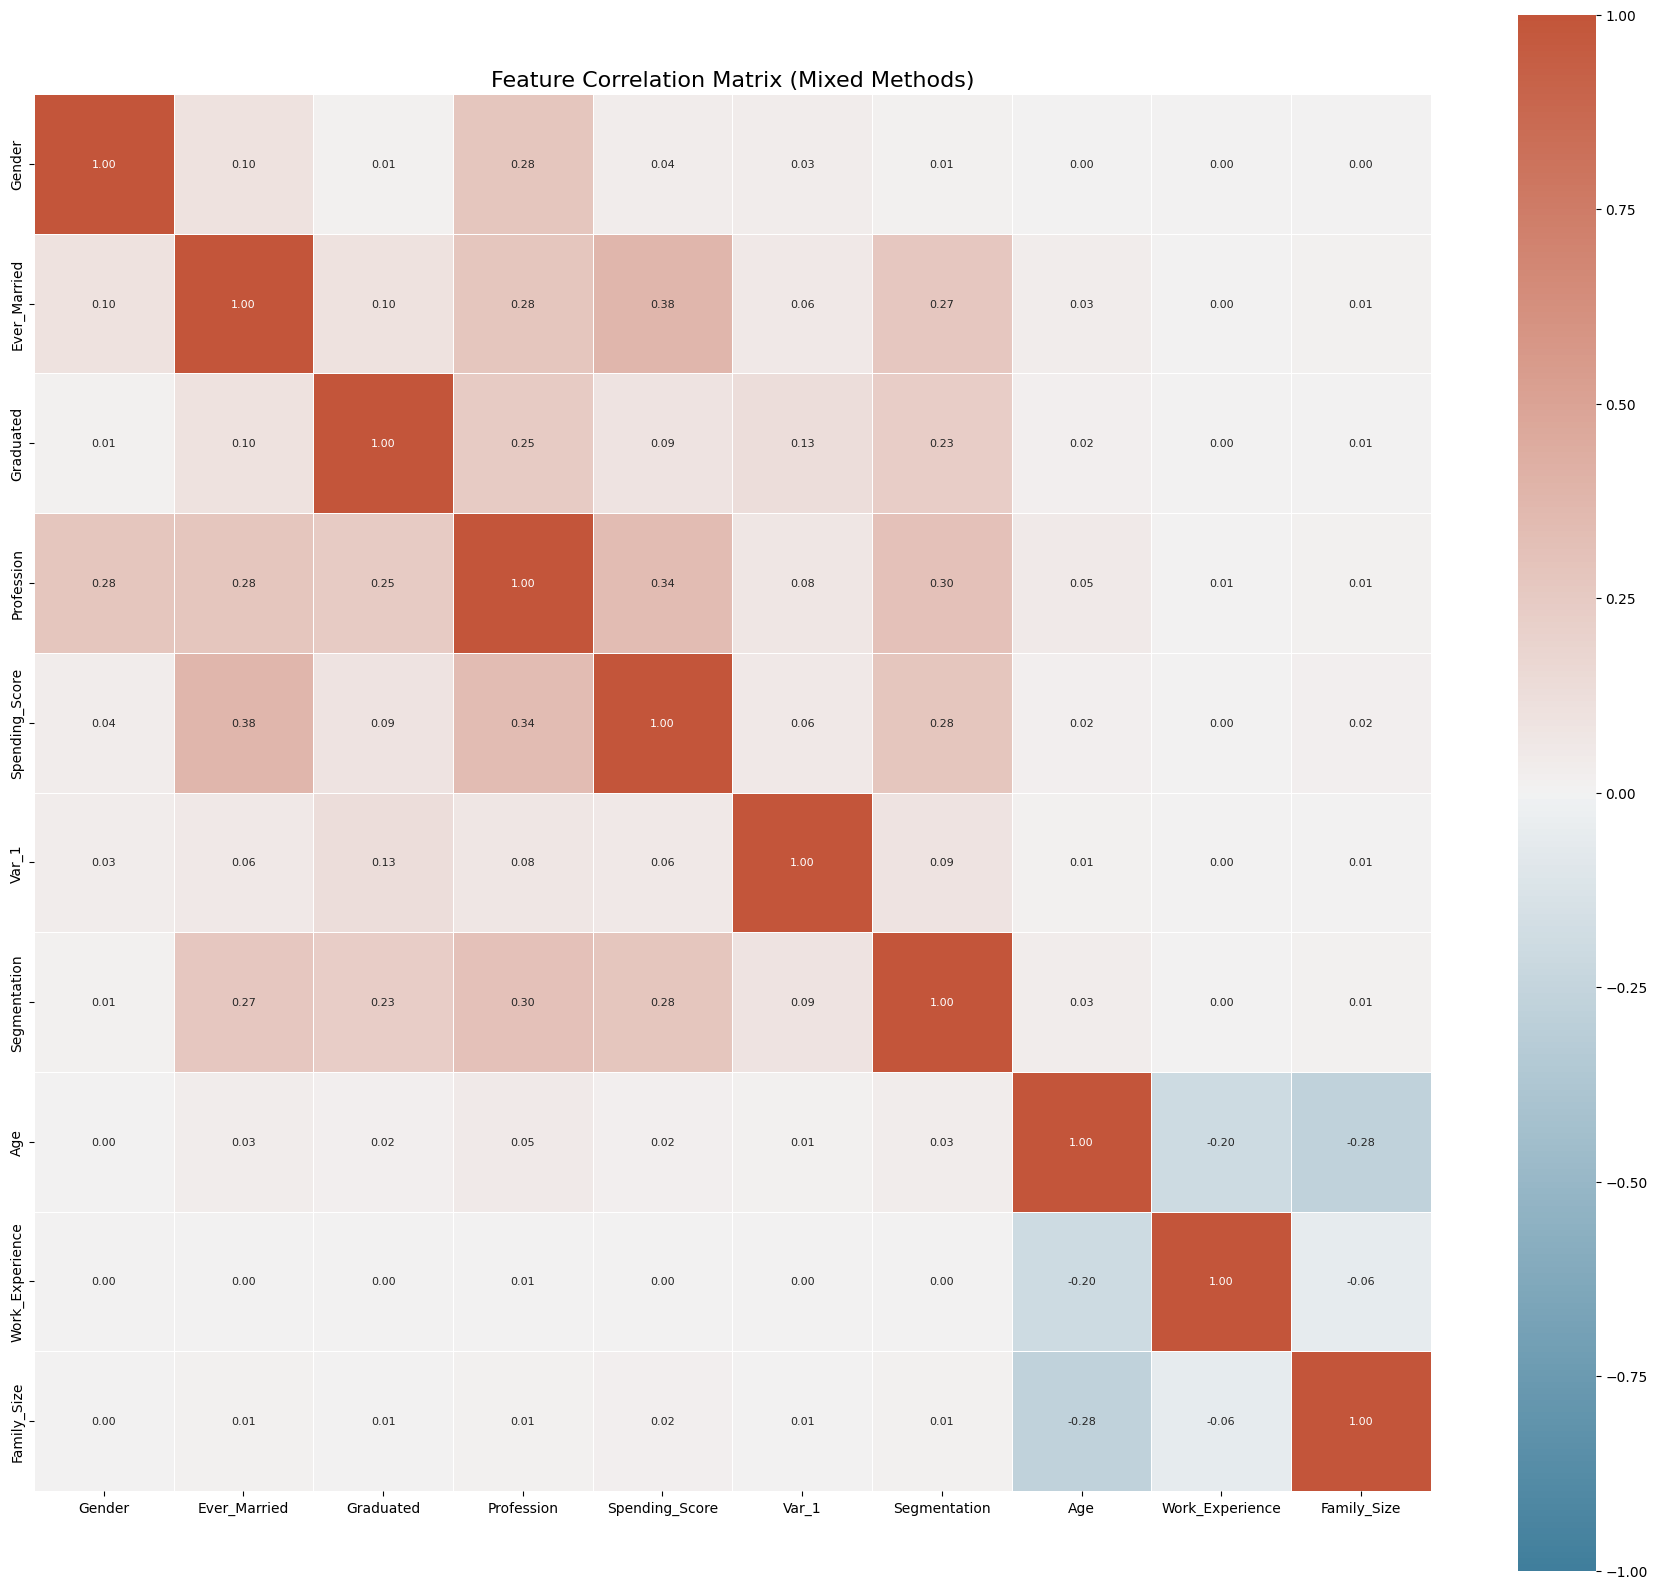

In [536]:
from sklearn.preprocessing import LabelEncoder

corr_df = train_df.copy()

le = LabelEncoder()
corr_df['Segmentation_Numeric'] = le.fit_transform(corr_df['Segmentation'])

# Korelasi tiap fitur
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.metrics import mutual_info_score
from sklearn.preprocessing import LabelEncoder

def cramers_v(x, y):
    # Convert to categorical if not already
    x = pd.Categorical(x)
    y = pd.Categorical(y)
    
    # Create contingency table
    confusion_matrix = pd.crosstab(x, y)
    
    # Calculate Chi-square
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    
    # Calculate Cramer's V
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

# Create a copy of the dataframe for encoding
encoded_df = train_df.copy()

# Identify categorical and numerical columns
categorical_cols = [col for col in train_df.columns if train_df[col].dtype == 'object']
numerical_cols = [col for col in train_df.columns if train_df[col].dtype != 'object' and col not in ['ID']]

# Encode all categorical variables for correlation calculation
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    encoded_df[col] = le.fit_transform(encoded_df[col].astype(str).fillna('missing'))
    label_encoders[col] = le

# Create a correlation matrix
all_features = categorical_cols + numerical_cols
n_features = len(all_features)
corr_matrix = np.zeros((n_features, n_features))

# Fill the correlation matrix - using different methods based on variable types
for i, feature1 in enumerate(all_features):
    for j, feature2 in enumerate(all_features):
        if i == j:
            corr_matrix[i, j] = 1.0  # Correlation with self is always 1
        else:
            # If both are numerical, use Pearson correlation
            if feature1 in numerical_cols and feature2 in numerical_cols:
                corr_matrix[i, j] = encoded_df[feature1].corr(encoded_df[feature2], method='pearson')
            # If both are categorical, use Cramer's V
            elif feature1 in categorical_cols and feature2 in categorical_cols:
                corr_matrix[i, j] = cramers_v(encoded_df[feature1], encoded_df[feature2])
            # If mixed, use mutual information (normalized)
            else:
                # Calculate mutual information
                mi = mutual_info_score(encoded_df[feature1].fillna(-999), 
                                       encoded_df[feature2].fillna(-999))
                # Normalize by entropy
                entropy = np.log(len(encoded_df[feature1].unique()) * len(encoded_df[feature2].unique()))
                if entropy > 0:
                    normalized_mi = mi / entropy
                    corr_matrix[i, j] = normalized_mi
                else:
                    corr_matrix[i, j] = 0

# Create a DataFrame for the correlation matrix
corr_df = pd.DataFrame(corr_matrix, index=all_features, columns=all_features)

# Plot the correlation matrix
plt.figure(figsize=(18, 16))

cmap = sns.diverging_palette(230, 20, as_cmap=True)  # Create colormap

# Plot heatmap
sns.heatmap(corr_df, cmap=cmap, vmax=1.0, vmin=-1.0, center=0,
            square=True, linewidths=.5, annot=True, fmt=".2f", annot_kws={"size": 8})
plt.title('Feature Correlation Matrix (Mixed Methods)', fontsize=16)
plt.tight_layout()
plt.show()




Cara Membaca, contoh: 
- Age di segmen A: Artinya Segmen A berasosiasi dengan Age tinggi secara lemah
- Family_Size di segmen A: Artinya Segmen A berasosiasi dengan Family_Size yang relatif kecil

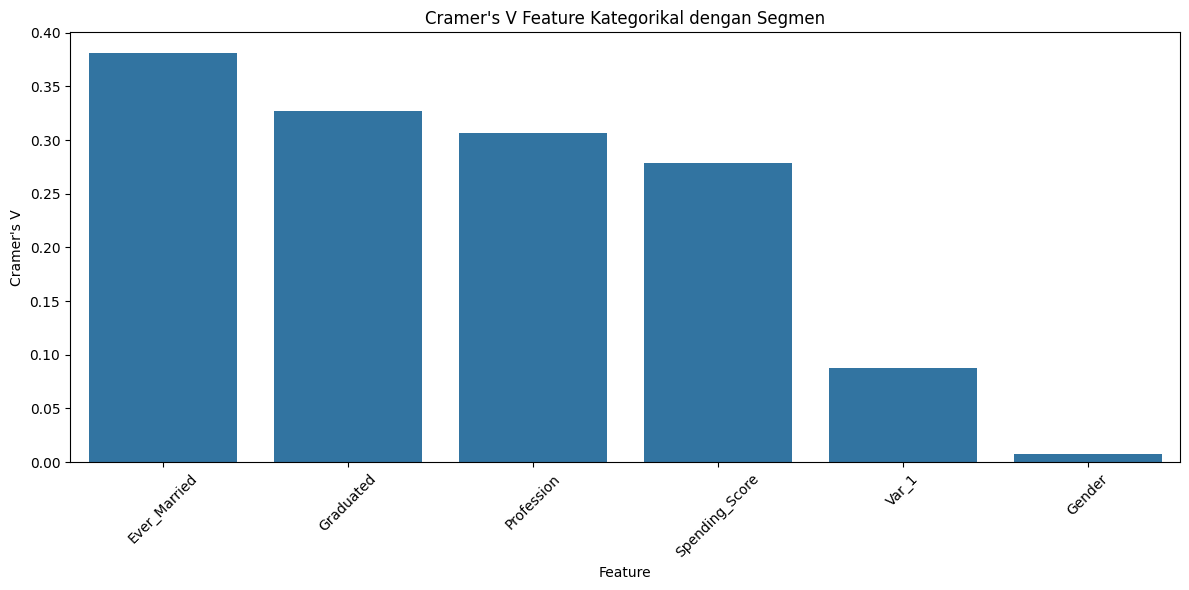

In [537]:
from sklearn.metrics import mutual_info_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

categorical_features = ['Gender', 'Ever_Married', 'Graduated', 'Profession', 'Spending_Score', 'Var_1']

from scipy.stats import chi2_contingency

def cramers_v(x, y):
    contingency_table = pd.crosstab(x, y)
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    n = contingency_table.sum().sum()
    phi2 = chi2 / n
    r, k = contingency_table.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

# Calculate Cramer's V for each categorical feature
cramers_results = {}
for feature in categorical_features:
    temp_df = train_df.dropna(subset=[feature, 'Segmentation'])
    cramers_results[feature] = cramers_v(temp_df[feature], temp_df['Segmentation'])

cramers_df = pd.DataFrame({'Feature': list(cramers_results.keys()), 'Cramer\'s V': list(cramers_results.values())})
cramers_df = cramers_df.sort_values('Cramer\'s V', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='Feature', y='Cramer\'s V', data=cramers_df)
plt.title('Cramer\'s V Feature Kategorikal dengan Segmen')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


=== Outlier Detection and Analysis ===


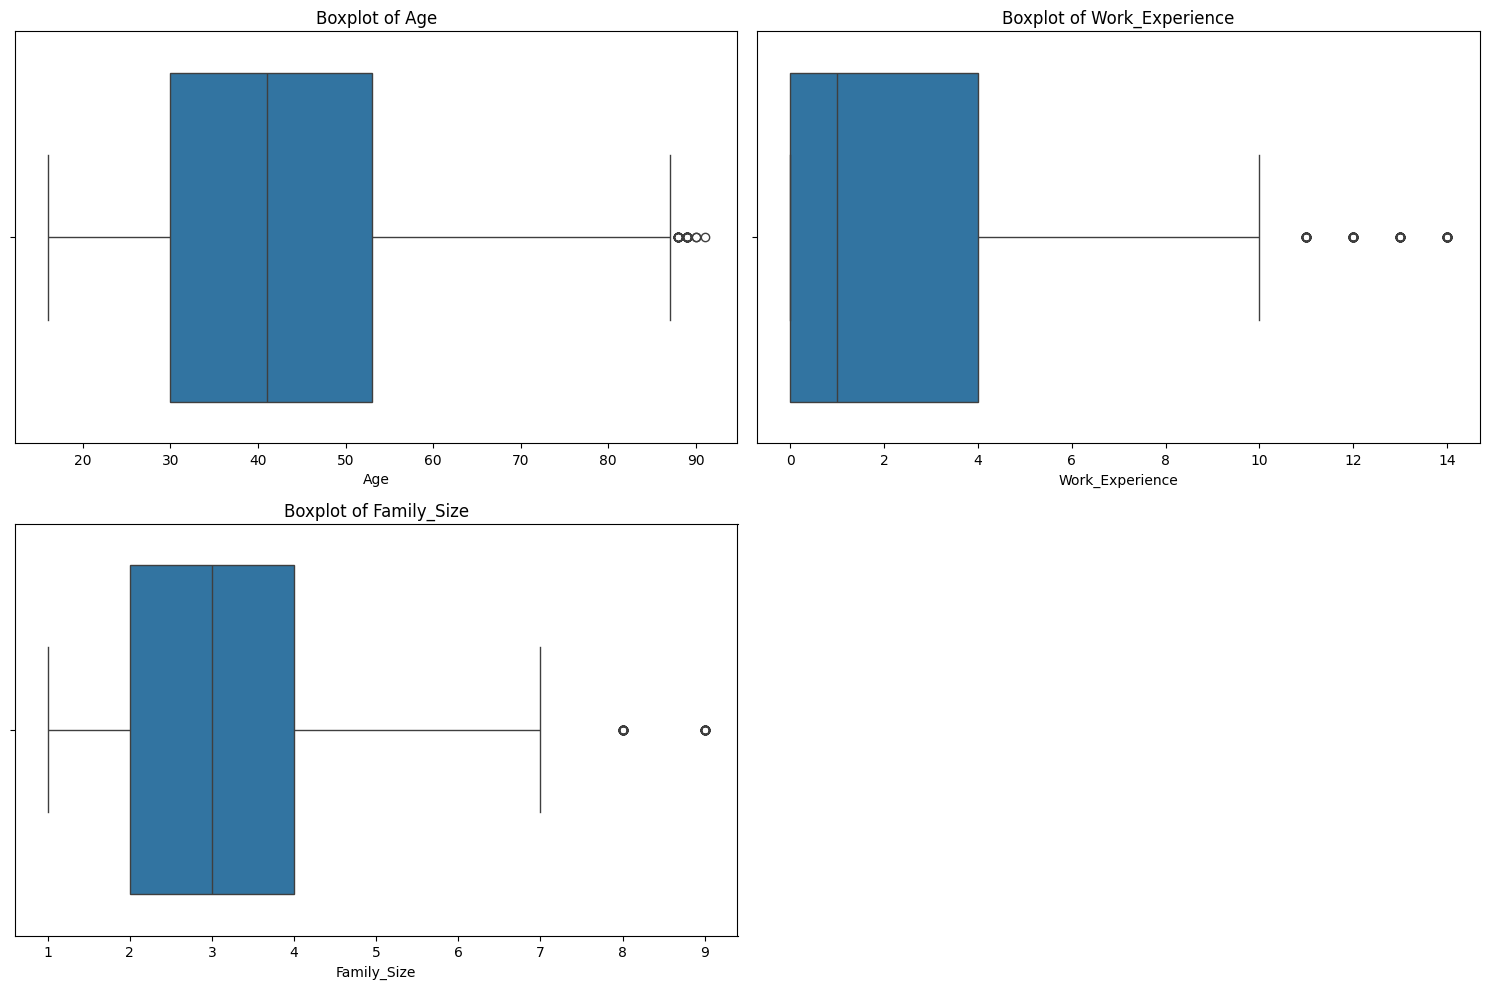


Outlier Statistics for Age:
  Q1: 30.00
  Median: 41.00
  Q3: 53.00
  IQR: 23.00
  Lower Bound: -4.50
  Upper Bound: 87.50
  Min: 16
  Max: 91
  Outliers Count: 50
  Outliers Percentage: 0.89

Outlier Statistics for Work_Experience:
  Q1: 0.00
  Median: 1.00
  Q3: 4.00
  IQR: 4.00
  Lower Bound: -6.00
  Upper Bound: 10.00
  Min: 0.00
  Max: 14.00
  Outliers Count: 139
  Outliers Percentage: 2.46

Outlier Statistics for Family_Size:
  Q1: 2.00
  Median: 3.00
  Q3: 4.00
  IQR: 2.00
  Lower Bound: -1.00
  Upper Bound: 7.00
  Min: 1.00
  Max: 9.00
  Outliers Count: 67
  Outliers Percentage: 1.19


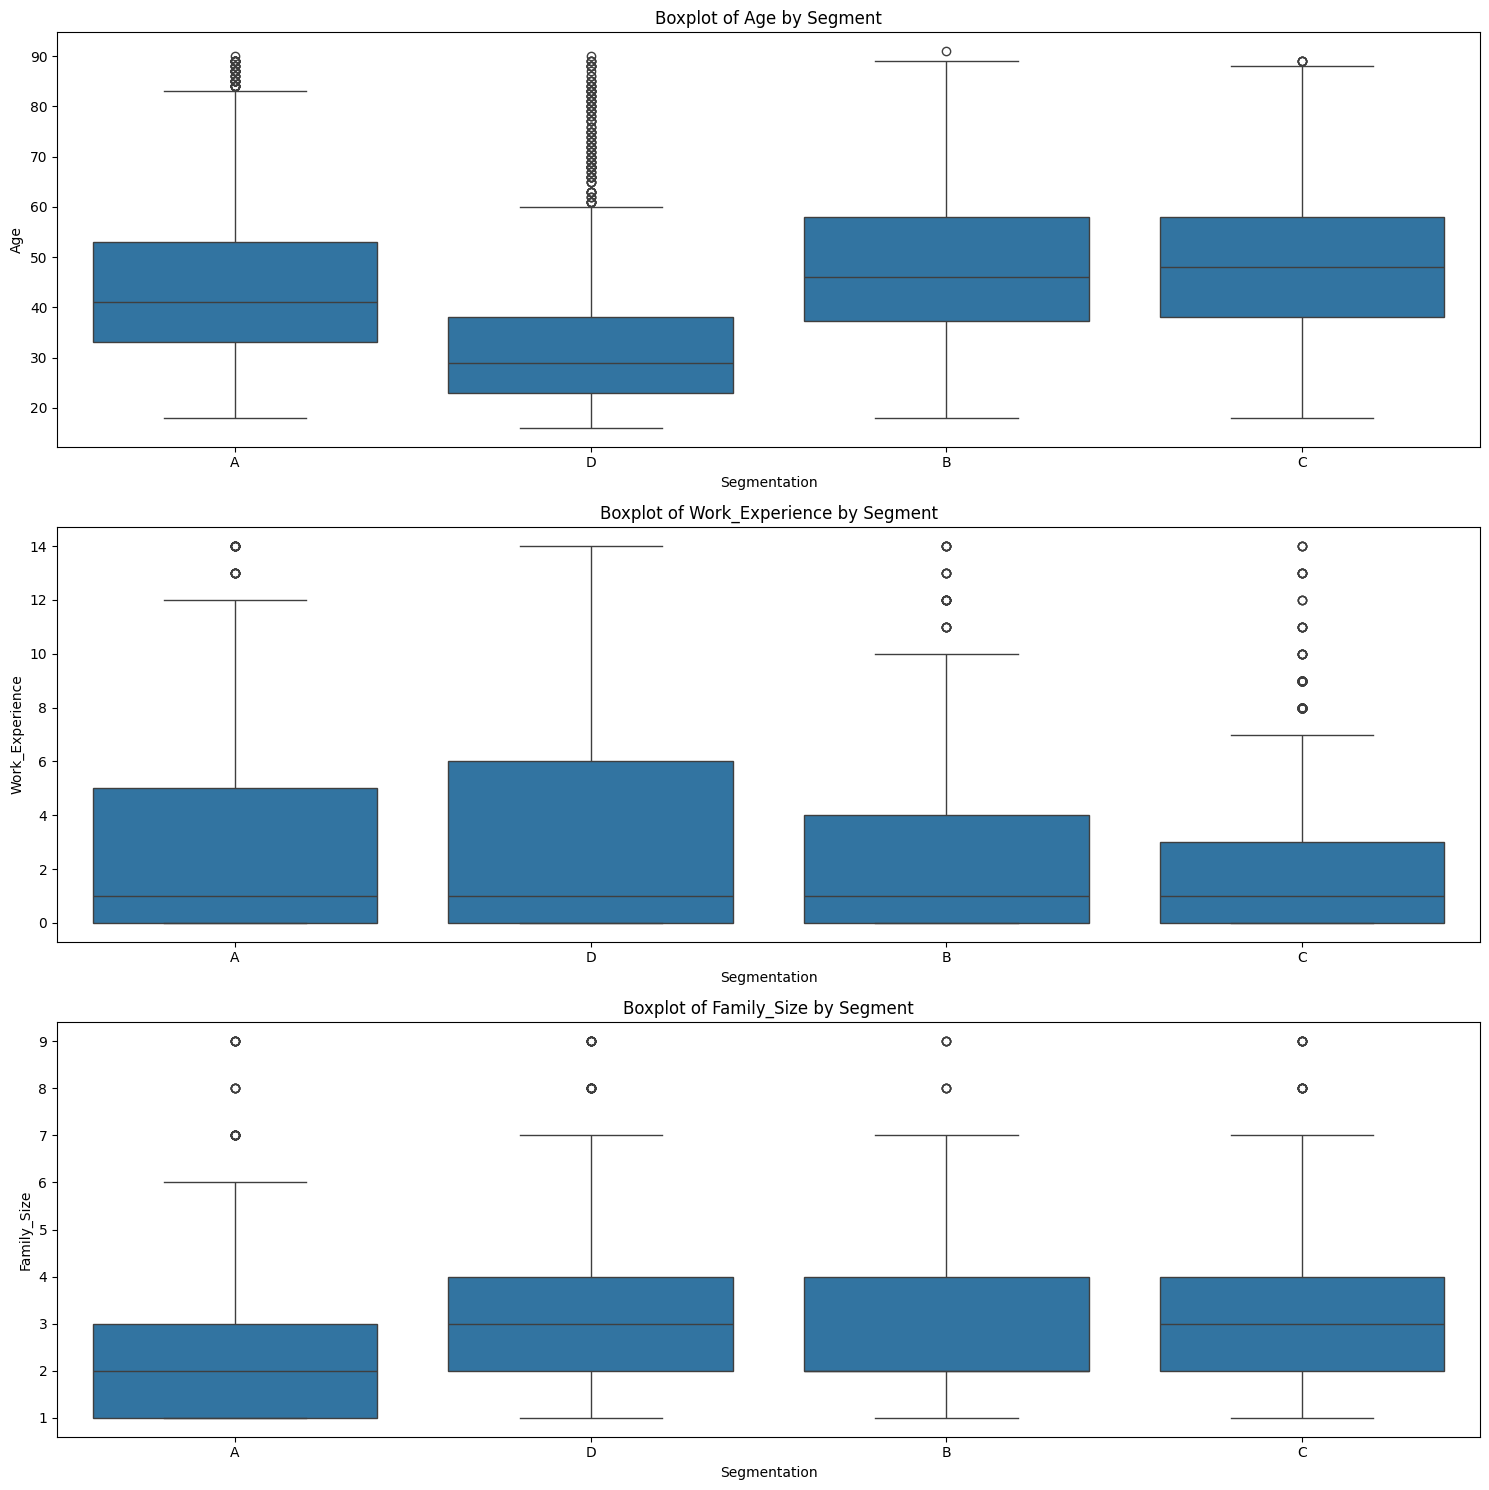

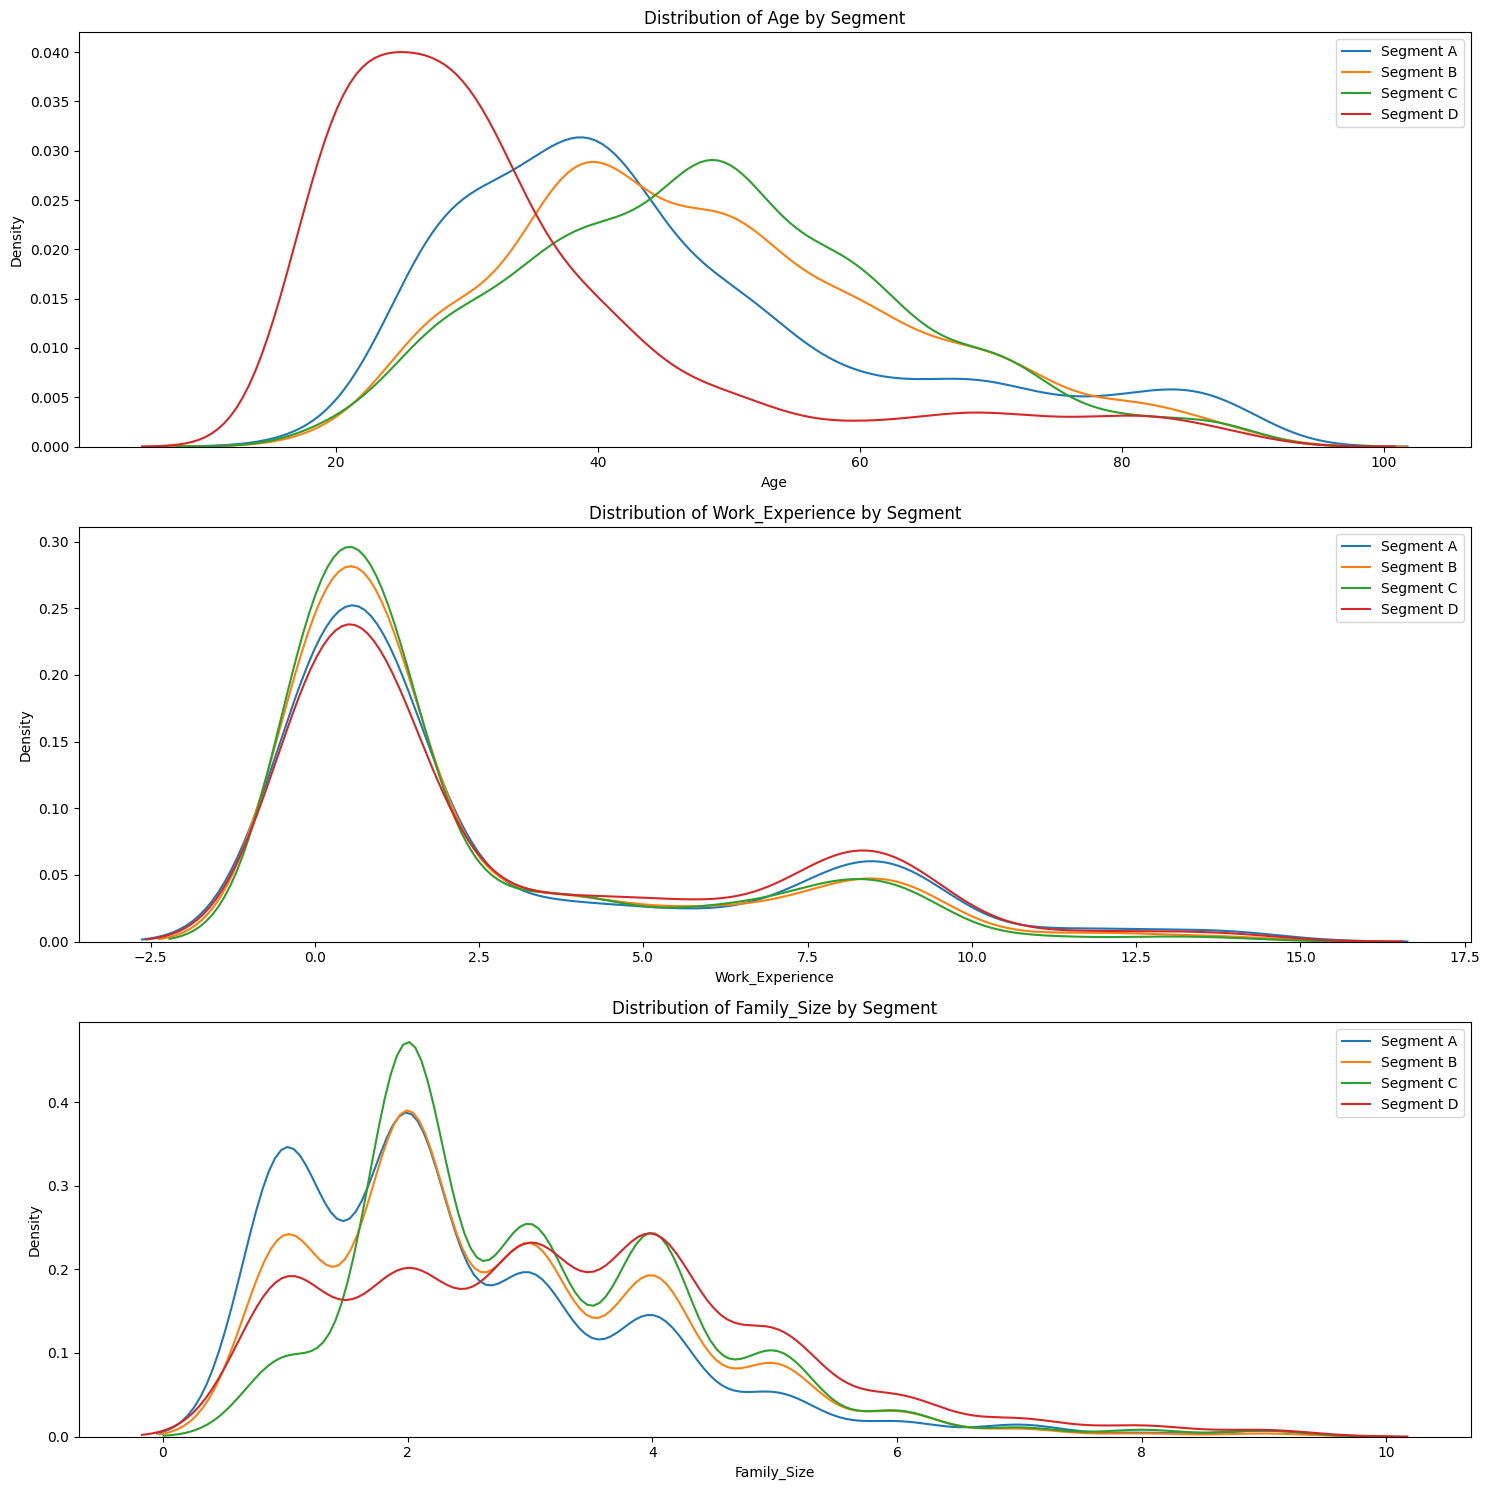

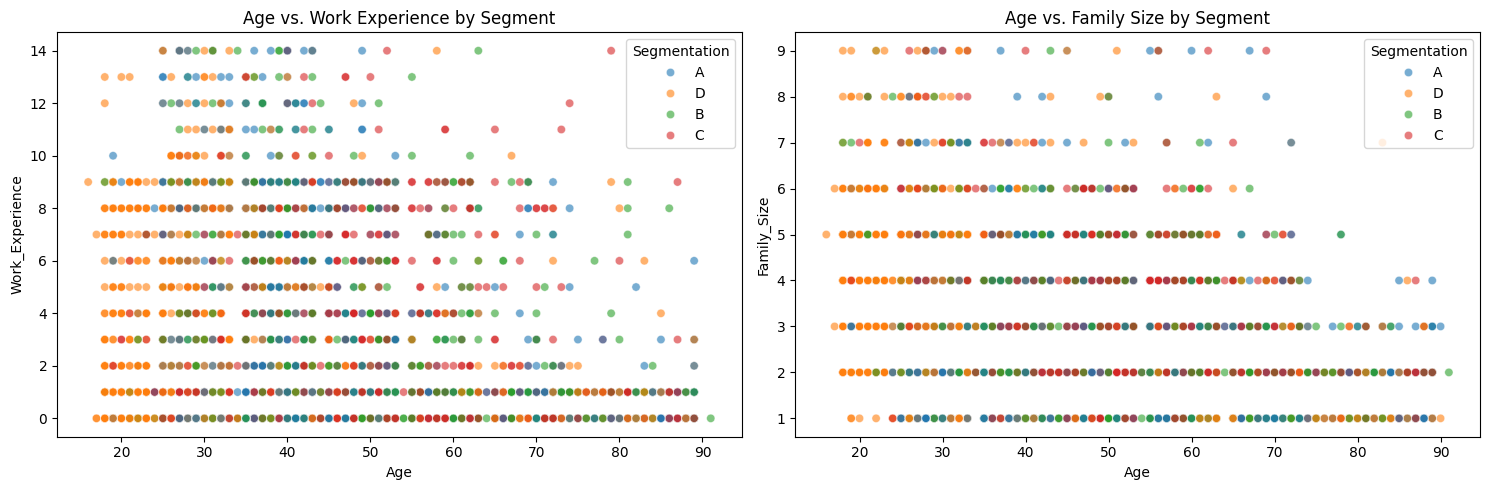


Z-Score Based Outlier Detection (|Z| > 3):
Age:
  Outliers Count: 0.00
  Outliers Percentage: 0.00
Work_Experience:
  Outliers Count: 67.00
  Outliers Percentage: 1.19
Family_Size:
  Outliers Count: 67.00
  Outliers Percentage: 1.19


In [538]:
# Outlier Detection and Analysis
print("=== Outlier Detection and Analysis ===")

# Focus on numerical features
numerical_features = ['Age', 'Work_Experience', 'Family_Size']

# Create boxplots to identify outliers
plt.figure(figsize=(15, 10))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x=train_df[feature])
    plt.title(f'Boxplot of {feature}')
    plt.tight_layout()
plt.show()

# Calculate outlier statistics
def get_outlier_stats(df, columns):
    stats = {}
    for col in columns:
        # Calculate Q1, Q3, and IQR
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        
        # Define outlier thresholds
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Count outliers
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        outliers_count = len(outliers)
        outliers_percentage = outliers_count / len(df) * 100
        
        # Store stats
        stats[col] = {
            'Q1': Q1,
            'Median': df[col].median(),
            'Q3': Q3,
            'IQR': IQR,
            'Lower Bound': lower_bound,
            'Upper Bound': upper_bound,
            'Min': df[col].min(),
            'Max': df[col].max(),
            'Outliers Count': outliers_count,
            'Outliers Percentage': outliers_percentage
        }
    return stats

# Get outlier statistics
outlier_stats = get_outlier_stats(train_df, numerical_features)

# Display outlier statistics
for feature, stats in outlier_stats.items():
    print(f"\nOutlier Statistics for {feature}:")
    for stat_name, stat_value in stats.items():
        if isinstance(stat_value, float):
            print(f"  {stat_name}: {stat_value:.2f}")
        else:
            print(f"  {stat_name}: {stat_value}")

# Visualize outliers with segment information
plt.figure(figsize=(15, 15))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(3, 1, i)
    sns.boxplot(x='Segmentation', y=feature, data=train_df)
    plt.title(f'Boxplot of {feature} by Segment')
    plt.tight_layout()
plt.show()

# KDE plots to visualize distributions
plt.figure(figsize=(15, 15))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(3, 1, i)
    for segment in sorted(train_df['Segmentation'].unique()):
        sns.kdeplot(train_df[train_df['Segmentation'] == segment][feature], label=f'Segment {segment}')
    plt.title(f'Distribution of {feature} by Segment')
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.legend()
    plt.tight_layout()
plt.show()

# Scatter plots to visualize relationships between numerical features and identify outliers
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x='Age', y='Work_Experience', hue='Segmentation', data=train_df, alpha=0.6)
plt.title('Age vs. Work Experience by Segment')

plt.subplot(1, 2, 2)
sns.scatterplot(x='Age', y='Family_Size', hue='Segmentation', data=train_df, alpha=0.6)
plt.title('Age vs. Family Size by Segment')
plt.tight_layout()
plt.show()

# Calculate Z-scores to identify outliers
from scipy import stats as scipy_stats

# Create a DataFrame to store Z-scores
z_scores = pd.DataFrame()
for feature in numerical_features:
    z_scores[feature] = scipy_stats.zscore(train_df[feature].fillna(train_df[feature].median()))

# Count outliers using Z-score > 3 as threshold
z_score_outliers = {}
for feature in numerical_features:
    outliers_count = len(z_scores[abs(z_scores[feature]) > 3])
    outliers_percentage = outliers_count / len(train_df) * 100
    z_score_outliers[feature] = {
        'Outliers Count': outliers_count,
        'Outliers Percentage': outliers_percentage
    }

print("\nZ-Score Based Outlier Detection (|Z| > 3):")
for feature, stats in z_score_outliers.items():
    print(f"{feature}:")
    for stat_name, stat_value in stats.items():
        print(f"  {stat_name}: {stat_value:.2f}")

# 2. Split Training Set and Validation Set

Splitting the training and validation set works as an early diagnostic towards the performance of the model we train. This is done before the preprocessing steps to **avoid data leakage inbetween the sets**. If you want to use k-fold cross-validation, split the data later and do the cleaning and preprocessing separately for each split.

Note: For training, you should use the data contained in the `Train_processed.csv` given by the TA. The `test_processed_no_solution.csv` data is only used for kaggle submission.

In [539]:
# Features and target variable
X = train_df.drop('Segmentation', axis=1)
y = train_df['Segmentation']

# Keep original dataset for later use
original_X = X.copy()
original_y = y.copy()

# Split into training and validation sets (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set shape: {X_train.shape}, Validation set shape: {X_val.shape}")

Training set shape: (4517, 10), Validation set shape: (1130, 10)


# 3. Data Cleaning and Preprocessing

This step is the first thing to be done once a Data Scientist have grasped a general knowledge of the data. Raw data is **seldom ready for training**, therefore steps need to be taken to clean and format the data for the Machine Learning model to interpret.

By performing data cleaning and preprocessing, you ensure that your dataset is ready for model training, leading to more accurate and reliable machine learning results. These steps are essential for transforming raw data into a format that machine learning algorithms can effectively learn from and make predictions.

For each step that you will do, **please explain the reason why did you do that process. Write it in a markdown cell under the code cell you wrote.**

In [540]:
# Function to determine profession tiers from the data
def determine_profession_tiers(df):
    # Calculate the average spending level for each profession
    # Convert Spending_Score to numeric values
    spending_map = {'Low': 1, 'Average': 2, 'High': 3}
    
    # Create a temporary column with numeric spending scores
    df_temp = df.copy()
    df_temp['Spending_Numeric'] = df_temp['Spending_Score'].map(spending_map)
    
    # Group by profession and calculate average spending
    prof_spending = df_temp.groupby('Profession')['Spending_Numeric'].mean().reset_index()
    prof_spending = prof_spending.sort_values('Spending_Numeric', ascending=False)
    
    # Define thresholds for categorization
    high_threshold = prof_spending['Spending_Numeric'].quantile(0.33)  # Top third
    low_threshold = prof_spending['Spending_Numeric'].quantile(0.67)   # Bottom third
    
    # Create profession tier lists
    high_income_profs = prof_spending[prof_spending['Spending_Numeric'] >= high_threshold]['Profession'].tolist()
    medium_income_profs = prof_spending[(prof_spending['Spending_Numeric'] < high_threshold) & 
                                       (prof_spending['Spending_Numeric'] >= low_threshold)]['Profession'].tolist()
    low_income_profs = prof_spending[prof_spending['Spending_Numeric'] < low_threshold]['Profession'].tolist()
    
    return high_income_profs, medium_income_profs, low_income_profs

In [541]:
# Function to determine education requirement for professions from data
def determine_education_requirements(df):
    # Calculate the percentage of graduates for each profession
    prof_edu = df.groupby('Profession')['Graduated'].apply(
        lambda x: (x == 'Yes').mean() if not x.isnull().all() else 0
    ).reset_index()
    
    prof_edu = prof_edu.sort_values('Graduated', ascending=False)
    
    # Define threshold for high education requirement (top third of professions by graduate %)
    high_threshold = prof_edu['Graduated'].quantile(0.33)
    
    # Create profession lists
    high_edu_profs = prof_edu[prof_edu['Graduated'] >= high_threshold]['Profession'].tolist()
    
    return high_edu_profs

In [542]:
def add_engineered_features(df, profession_tiers=None):
    # Make a copy to avoid modifying the original dataframe
    df_new = df.copy()
    
    # Create Age related features based on correlation findings
    df_new['Age_Squared'] = df_new['Age'] ** 2  # Polynomial feature to capture non-linear relationships
    
    # Create age groups (our EDA showed age is significant for segmentation)
    bins = [0, 25, 35, 45, 55, 65, 100]
    labels = ['Under_25', '25_35', '35_45', '45_55', '55_65', 'Over_65']
    df_new['Age_Group'] = pd.cut(df_new['Age'], bins=bins, labels=labels)
    
    # Create feature interaction between Age and Family_Size (negative correlation)
    df_new['Age_Family_Ratio'] = df_new['Age'] / df_new['Family_Size'].replace(0, 1)  # Avoid division by zero
    
    # Use the data-driven profession tiers if provided
    if profession_tiers:
        high_income_professions, medium_income_professions, _ = profession_tiers
        df_new['Is_High_Value_Profession'] = df_new['Profession'].isin(high_income_professions)
    else:
        # Fallback to hard-coded list if tiers weren't provided
        df_new['Is_High_Value_Profession'] = df_new['Profession'].isin(['Doctor', 'Executive', 'Lawyer'])
    
    df_new['Married_Age_Interaction'] = 0
    married_mask = df_new['Ever_Married'] == 'Yes'
    df_new.loc[married_mask, 'Married_Age_Interaction'] = df_new.loc[married_mask, 'Age']
    
    df_new['Graduated_Age_Interaction'] = 0
    graduated_mask = df_new['Graduated'] == 'Yes'
    df_new.loc[graduated_mask, 'Graduated_Age_Interaction'] = df_new.loc[graduated_mask, 'Age']
    
    # FEATURE 1: Married_Spending (ever_married and spending_score)
    # Create a single feature that captures the relationship
    df_new['Married_Spending'] = 'Unknown'
    
    # Define the combinations
    df_new.loc[(df_new['Ever_Married'] == 'Yes') & (df_new['Spending_Score'] == 'High'), 'Married_Spending'] = 'Married_High'
    df_new.loc[(df_new['Ever_Married'] == 'Yes') & (df_new['Spending_Score'] == 'Average'), 'Married_Spending'] = 'Married_Average'
    df_new.loc[(df_new['Ever_Married'] == 'Yes') & (df_new['Spending_Score'] == 'Low'), 'Married_Spending'] = 'Married_Low'
    df_new.loc[(df_new['Ever_Married'] == 'No') & (df_new['Spending_Score'] == 'High'), 'Married_Spending'] = 'Single_High'
    df_new.loc[(df_new['Ever_Married'] == 'No') & (df_new['Spending_Score'] == 'Average'), 'Married_Spending'] = 'Single_Average'
    df_new.loc[(df_new['Ever_Married'] == 'No') & (df_new['Spending_Score'] == 'Low'), 'Married_Spending'] = 'Single_Low'
    
    # FEATURE 2: Prof_Spending (profession and spending_score)
    # Create a single feature for profession and spending
    
    # First categorize professions into tiers
    df_new['Prof_Tier'] = 'Other'
    
    if profession_tiers:
        high_income_professions, medium_income_professions, _ = profession_tiers
        df_new.loc[df_new['Profession'].isin(high_income_professions), 'Prof_Tier'] = 'High'
        df_new.loc[df_new['Profession'].isin(medium_income_professions), 'Prof_Tier'] = 'Medium'
    else:
        # Fallback to default categorization
        default_high = ['Doctor', 'Lawyer', 'Executive']
        default_medium = ['Engineer', 'Healthcare', 'Marketing', 'Artist']
        df_new.loc[df_new['Profession'].isin(default_high), 'Prof_Tier'] = 'High'
        df_new.loc[df_new['Profession'].isin(default_medium), 'Prof_Tier'] = 'Medium'
    
    # Create the combined feature
    df_new['Prof_Spending'] = df_new['Prof_Tier'] + '_' + df_new['Spending_Score']

    # FEATURE 4: Age and Work Experience inverse correlation
    # Fill any missing Work_Experience values for this calculation
    
    # Create a feature that captures the "experience gap"
    # Assumption: At age X, a person could have up to X-18 years of experience (starting work at 18)
    # df_new['Experience_Gap'] = (df_new['Age'] - 18) - work_exp_filled
    # df_new['Experience_Gap'] = df_new['Experience_Gap'].clip(lower=0)  # Ensure no negative values
    
    # Create a normalized ratio of actual to potential experience
    # df_new['Experience_Ratio'] = df_new['Work_Experience'] / (df_new['Age']).clip(lower=1)

    # # Create a categorical feature for experience level relative to age
    # df_new['Experience_Level'] = 'Medium'
    # df_new.loc[df_new['Experience_Ratio'] < 0.2, 'Experience_Level'] = 'Low'
    # df_new.loc[df_new['Experience_Ratio'] > 0.6, 'Experience_Level'] = 'High'
    
    # A binary indicator for unusually low experience for age
    # df_new['Underexperienced'] = 0
    # # Define underexperienced as having less than 20% of potential experience
    # df_new.loc[df_new['Experience_Ratio'] < 0.2, 'Underexperienced'] = 1
    
    # # Create a categorical feature for experience level relative to age
    # df_new['Experience_Level'] = 'Medium'
    # df_new.loc[df_new['Experience_Ratio'] < 0.2, 'Experience_Level'] = 'Low'
    # df_new.loc[df_new['Experience_Ratio'] > 0.6, 'Experience_Level'] = 'High'
    
    return df_new

# Determine profession income tiers from data
high_income_profs, medium_income_profs, low_income_profs = determine_profession_tiers(train_df)
profession_tiers = (high_income_profs, medium_income_profs, low_income_profs)

# Use these tiers in feature engineering
X_train_enhanced = add_engineered_features(X_train, profession_tiers=profession_tiers)
X_val_enhanced = add_engineered_features(X_val, profession_tiers=profession_tiers)

# Update feature lists for the preprocessor
numerical_features = ['Age', 'Work_Experience', 'Family_Size', 'Age_Squared', 'Age_Family_Ratio', 
                      'Married_Age_Interaction', 'Graduated_Age_Interaction']

categorical_features = ['Gender', 'Ever_Married', 'Graduated', 'Profession', 'Spending_Score', 'Var_1', 
                        'Age_Group', 'Is_High_Value_Profession', 'Married_Spending', 'Prof_Spending']

# Define preprocessing for numerical features
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Define preprocessing for categorical features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Compile Preprocessing Pipeline

All of the preprocessing classes or functions defined earlier will be compiled in this step.

If you use sklearn to create preprocessing classes, you can list your preprocessing classes in the Pipeline object sequentially, and then fit and transform your data.

In [543]:
# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop'  # Drop ID column and other unnecessary columns
)

or create your own here

# 4. Modeling and Validation

Modelling is the process of building your own machine learning models to solve specific problems, or in this assignment context, predicting the probability for each class in the `Segmentation` feature. Validation is the process of evaluating your trained model using the validation set or cross-validation method and providing some metrics that can help you decide what to do in the next iteration of development.

In this task, you are required to predict each class in the Segmentation feature using Ensemble Learning algorithms.

## 4.1 Ensemble

Implement **at least 1 model** for each of the following learning algorithms:

- Bagging
- Boosting
- Stacking
- Voting

### 4.1.1 Bagging
Bagging is a technique that trains a single type of model, with each model being trained on a different subset of the data. The final prediction is determined by the most frequently occurring prediction across all models. As a reference, you may use `RandomForestClassifier` to build your bagging model.

Training Random Forest with RandomizedSearchCV...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters: {'classifier__n_estimators': 100, 'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 1, 'classifier__max_features': 'log2', 'classifier__max_depth': 10, 'classifier__class_weight': 'balanced'}
Best cross-validation score: 0.4924
Random Forest (Bagging) - Macro F1 Score: 0.5037

Classification Report (Random Forest):
              precision    recall  f1-score   support

           A       0.43      0.46      0.45       275
           B       0.41      0.33      0.36       261
           C       0.56      0.56      0.56       278
           D       0.62      0.68      0.65       316

    accuracy                           0.52      1130
   macro avg       0.50      0.51      0.50      1130
weighted avg       0.51      0.52      0.51      1130



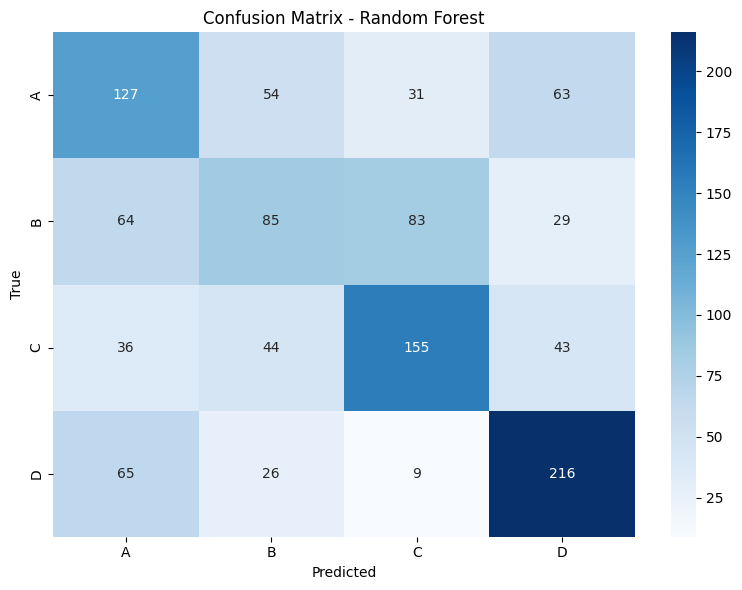

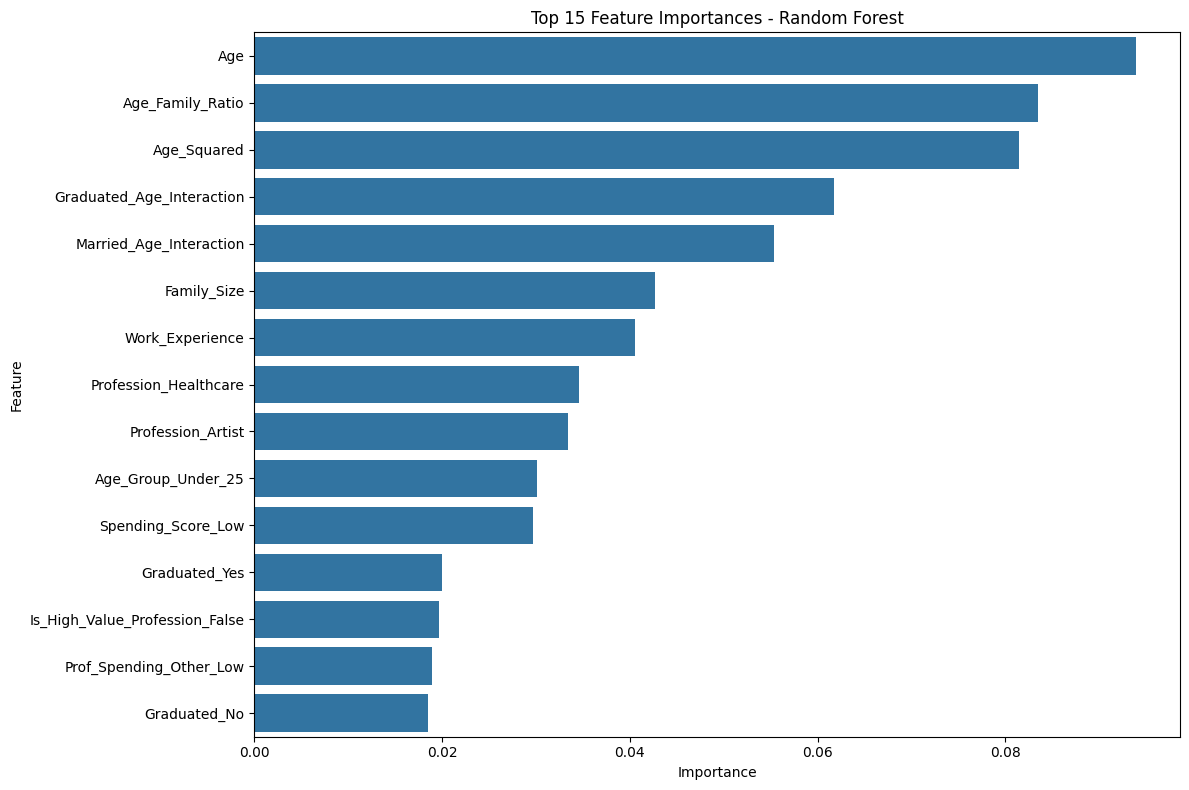

In [544]:
# Random Forest Classifier (Bagging algorithm) with hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV

# Define the parameter grid for random forest
rf_param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__max_features': ['sqrt', 'log2'],
    'classifier__class_weight': ['balanced', 'balanced_subsample', None]
}

# Create a base random forest pipeline
rf_base = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Set up RandomizedSearchCV
rf_random = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=rf_param_grid,
    n_iter=20,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# Fit the random search to the data
print("Training Random Forest with RandomizedSearchCV...")
rf_random.fit(X_train_enhanced, y_train)

print(f"Best parameters: {rf_random.best_params_}")
print(f"Best cross-validation score: {rf_random.best_score_:.4f}")

# Use the best model
rf_classifier = rf_random.best_estimator_

# Make predictions with the best model
rf_predictions = rf_classifier.predict(X_val_enhanced)

# Evaluate the model
rf_f1_macro = f1_score(y_val, rf_predictions, average='macro')
print(f"Random Forest (Bagging) - Macro F1 Score: {rf_f1_macro:.4f}")

# Display classification report
print("\nClassification Report (Random Forest):")
print(classification_report(y_val, rf_predictions))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_val, rf_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=sorted(y.unique()), yticklabels=sorted(y.unique()))
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

# Feature importance analysis
if hasattr(rf_classifier.named_steps['classifier'], 'feature_importances_'):
    # Get feature names
    feature_names = []
    
    # Get column names from numerical features
    num_feature_names = numerical_features
    
    # Get one-hot encoded feature names from categorical features
    cat_encoder = rf_classifier.named_steps['preprocessor'].transformers_[1][1].named_steps['onehot']
    cat_feature_names = []
    for i, feature in enumerate(categorical_features):
        encoded_features = [f"{feature}_{cat}" for cat in cat_encoder.categories_[i]]
        cat_feature_names.extend(encoded_features)
    
    # Combine all feature names
    feature_names = num_feature_names + cat_feature_names
    
    # Get feature importances
    importances = rf_classifier.named_steps['classifier'].feature_importances_
    
    # Create a DataFrame for visualization
    feature_imp = pd.DataFrame({
        'Feature': feature_names[:len(importances)],  # Ensure lengths match
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    
    # Plot top 15 feature importances
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_imp.head(15))
    plt.title('Top 15 Feature Importances - Random Forest')
    plt.tight_layout()
    plt.show()

### 4.1.2 Boosting
Boosting is a technique where the first model is trained on entire dataset, the second model to reduce the error of first model, followed by a third model to reduce the error of the second model, and so on. As a reference, you may use `GradientBoostingClassifier` to build your boosting model.

Training XGBoost with RandomizedSearchCV...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters: {'classifier__subsample': 1.0, 'classifier__scale_pos_weight': 1, 'classifier__n_estimators': 100, 'classifier__min_child_weight': 3, 'classifier__max_depth': 3, 'classifier__learning_rate': 0.05, 'classifier__gamma': 0, 'classifier__colsample_bytree': 1.0}
Best cross-validation score: 0.4916
XGBoost (Boosting) - Macro F1 Score: 0.4961

Classification Report (XGBoost):
              precision    recall  f1-score   support

           A       0.44      0.40      0.42       275
           B       0.41      0.30      0.34       261
           C       0.55      0.60      0.57       278
           D       0.59      0.72      0.65       316

    accuracy                           0.52      1130
   macro avg       0.50      0.50      0.50      1130
weighted avg       0.50      0.52      0.50      1130



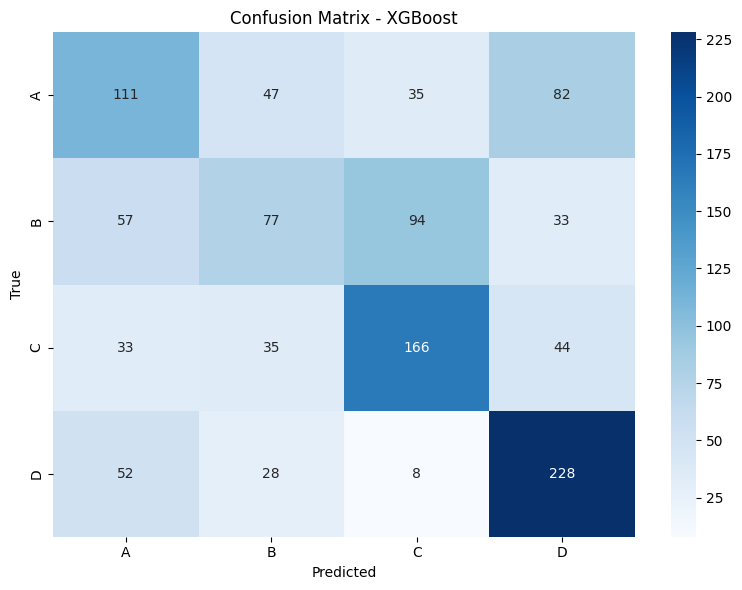

In [545]:

# Add a label encoder for the target variable
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier

xgb_param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [3, 5, 7, 9],
    'classifier__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'classifier__subsample': [0.7, 0.8, 0.9, 1.0],
    'classifier__colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'classifier__min_child_weight': [1, 3, 5],
    'classifier__gamma': [0, 0.1, 0.2],
    'classifier__scale_pos_weight': [1, 3, 5]  # For imbalanced classes if needed
}

# Create a label encoder
le = LabelEncoder()

# Fit the encoder on all possible classes from the original dataset
le.fit(original_y)

# When training XGBoost, use the encoded labels
# Modify the XGBoost training section:

# Create base XGBoost pipeline
xgb_base = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(objective='multi:softprob', random_state=42))
])

# Set up RandomizedSearchCV
xgb_random = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=xgb_param_grid,
    n_iter=20,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# Convert target to numerical values for XGBoost
y_train_encoded = le.transform(y_train)

# Fit the random search to the data
print("Training XGBoost with RandomizedSearchCV...")
xgb_random.fit(X_train_enhanced, y_train_encoded)

print(f"Best parameters: {xgb_random.best_params_}")
print(f"Best cross-validation score: {xgb_random.best_score_:.4f}")

# Use the best model
xgb_classifier = xgb_random.best_estimator_

# For prediction, we need to convert back to original labels
xgb_predictions_encoded = xgb_classifier.predict(X_val_enhanced)
xgb_predictions = le.inverse_transform(xgb_predictions_encoded)

# Evaluate the model
xgb_f1_macro = f1_score(y_val, xgb_predictions, average='macro')
print(f"XGBoost (Boosting) - Macro F1 Score: {xgb_f1_macro:.4f}")

# Display classification report
print("\nClassification Report (XGBoost):")
print(classification_report(y_val, xgb_predictions))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_val, xgb_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=sorted(y.unique()), yticklabels=sorted(y.unique()))
plt.title('Confusion Matrix - XGBoost')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()


### 4.1.3 Voting
Voting is a technique that trains multiple different models, with each model being trained on the entire dataset. The final prediction is obtained through voting. As a reference, you may use `VotingClassifier` to build your voting model.

Training Voting Classifier...
Weighted Voting Classifier - Macro F1 Score: 0.5110

Classification Report (Voting Classifier):
              precision    recall  f1-score   support

           A       0.45      0.47      0.46       275
           B       0.43      0.30      0.35       261
           C       0.57      0.59      0.58       278
           D       0.60      0.71      0.65       316

    accuracy                           0.53      1130
   macro avg       0.51      0.52      0.51      1130
weighted avg       0.52      0.53      0.52      1130



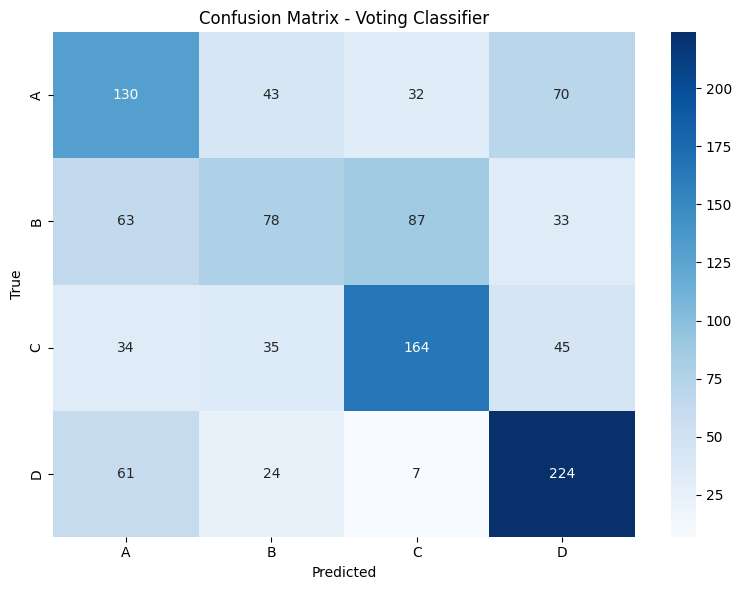

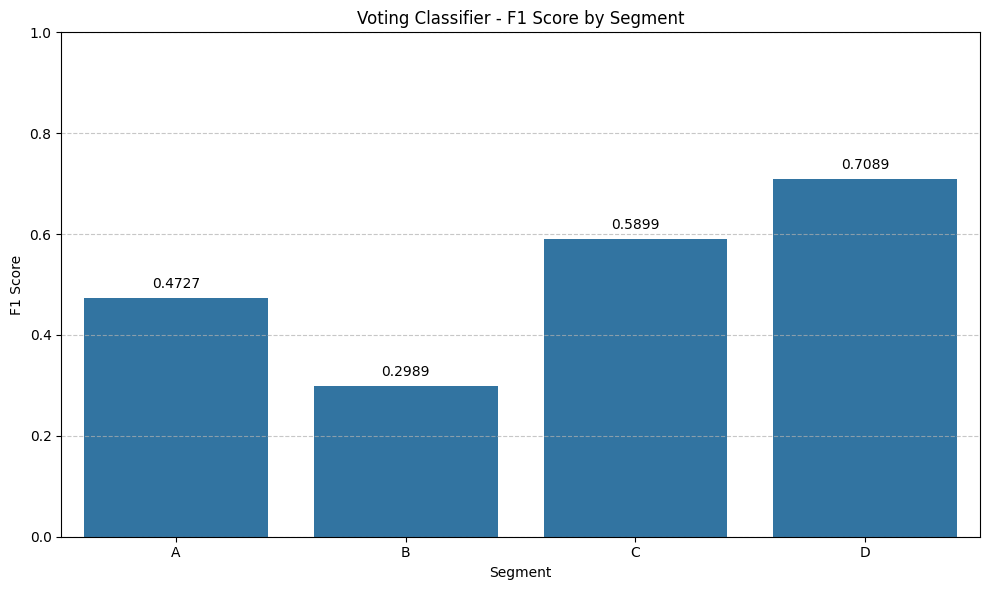

In [546]:
# Define improved base classifiers for voting
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

# Use our optimized Random Forest classifier instead of a basic one
if 'rf_classifier' in locals():
    clf1 = rf_classifier.named_steps['classifier']
else:
    clf1 = RandomForestClassifier(
        n_estimators=200, 
        max_depth=20,
        min_samples_split=5,
        class_weight='balanced',
        random_state=42
    )

# Use our optimized XGBoost classifier instead of GradientBoosting
if 'xgb_classifier' in locals():
    clf2 = xgb_classifier.named_steps['classifier']
else:
    clf2 = XGBClassifier(
        n_estimators=200,
        max_depth=7,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )

# Add more diverse classifiers based on different algorithms
clf3 = LogisticRegression(
    C=1.0,
    max_iter=2000,
    class_weight='balanced',
    multi_class='multinomial',
    solver='lbfgs',
    random_state=42
)

clf4 = SVC(
    probability=True,  # Required for soft voting
    C=1.0,
    kernel='rbf',
    class_weight='balanced',
    random_state=42
)

# Create a weighted voting classifier - give more weight to the best performers
voting_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', VotingClassifier(estimators=[
        ('rf', clf1),
        ('xgb', clf2),
        ('lr', clf3),
        ('svc', clf4)
    ], voting='soft', weights=[2, 2, 1, 1]))  # Give higher weights to tree-based models
])

# Train the model
print("Training Voting Classifier...")
voting_clf.fit(X_train_enhanced, y_train)

# Make predictions
voting_predictions = voting_clf.predict(X_val_enhanced)

# Evaluate the model
voting_f1_macro = f1_score(y_val, voting_predictions, average='macro')
print(f"Weighted Voting Classifier - Macro F1 Score: {voting_f1_macro:.4f}")

# Display classification report
print("\nClassification Report (Voting Classifier):")
print(classification_report(y_val, voting_predictions))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_val, voting_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=sorted(y.unique()), yticklabels=sorted(y.unique()))
plt.title('Confusion Matrix - Voting Classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

# Show the segment-specific performance
segment_performance = {}
for segment in sorted(y.unique()):
    segment_indices = y_val == segment
    if np.any(segment_indices):
        segment_f1 = f1_score(y_val[segment_indices], 
                              voting_predictions[segment_indices], 
                              average='micro')
        segment_performance[segment] = segment_f1

# Plot segment-specific performance
plt.figure(figsize=(10, 6))
segments = list(segment_performance.keys())
scores = list(segment_performance.values())
sns.barplot(x=segments, y=scores)
plt.title('Voting Classifier - F1 Score by Segment')
plt.xlabel('Segment')
plt.ylabel('F1 Score')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i, score in enumerate(scores):
    plt.text(i, score + 0.02, f"{score:.4f}", ha='center')

plt.tight_layout()
plt.show()

### 4.1.4 Stacking
Stacking is a technique that trains multiple different models, with each model being trained on the entire dataset. The final prediction is obtained through a meta-learner model that takes the predictions of the previous models as input. As a reference, you may use `StackingClassifier` to build your stacking model.


Training Stacking Classifier...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000357 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 644
[LightGBM] [Info] Number of data points in the train set: 4517, number of used features: 53
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

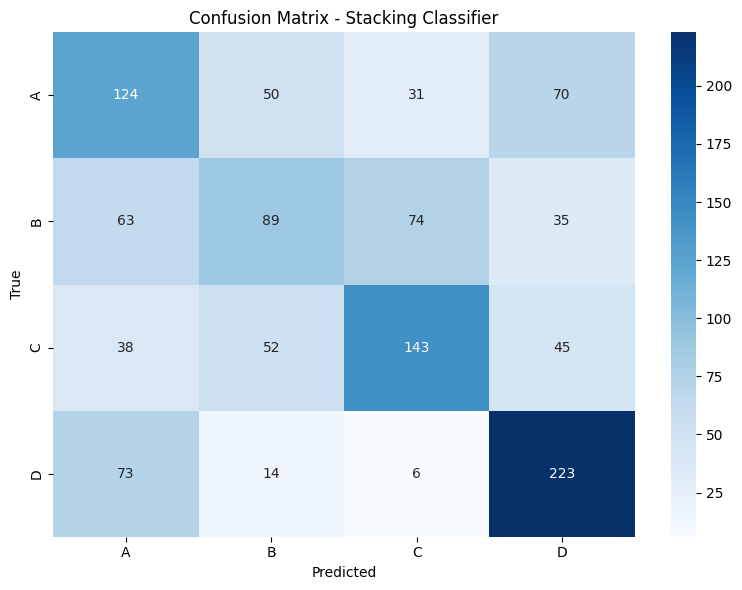


Validation set segment distribution:
Segment A: 275 samples (24.34%)
Segment B: 261 samples (23.10%)
Segment C: 278 samples (24.60%)
Segment D: 316 samples (27.96%)

Segment-specific performance metrics:
   precision    recall  f1-score  support
A   0.416107  0.450909  0.432810    275.0
B   0.434146  0.340996  0.381974    261.0
C   0.562992  0.514388  0.537594    278.0
D   0.597855  0.705696  0.647315    316.0


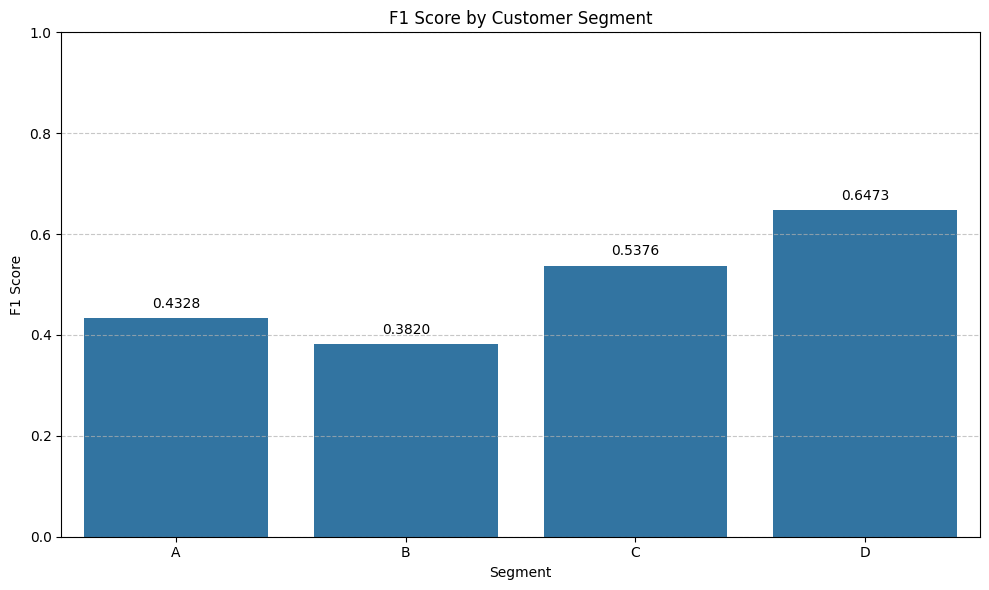


Top 5 most common misclassifications:
  True Predicted  count
0    B         C     74
1    D         A     73
2    A         D     70
3    B         A     63
4    C         B     52


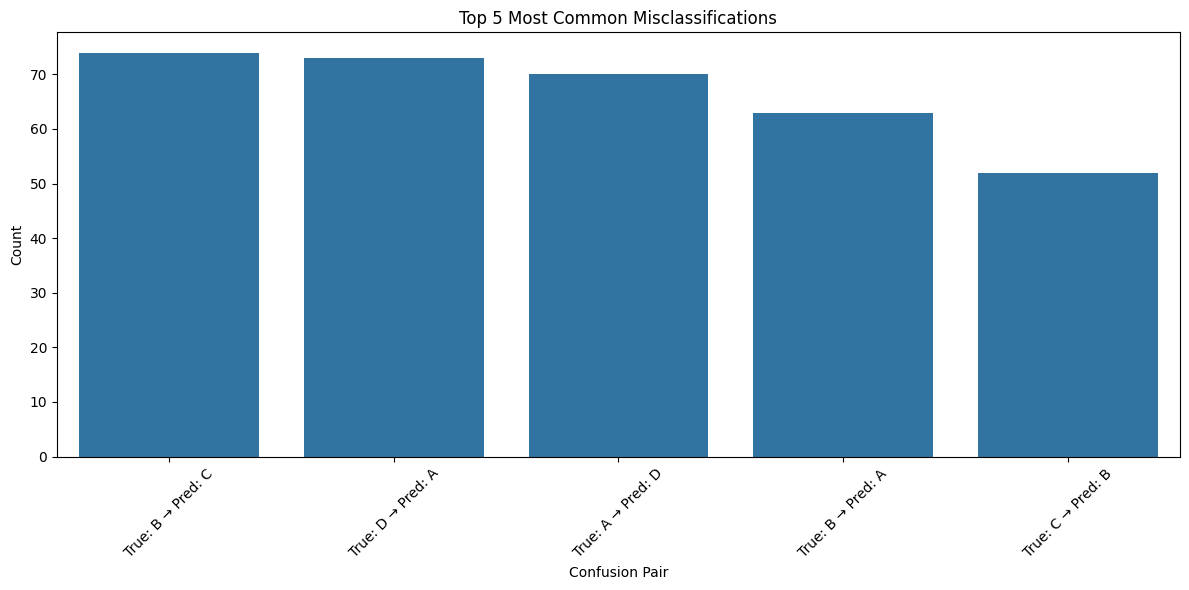

In [547]:
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

# Define improved base estimators for stacking
# Use our optimized models and add more diverse learners
estimators = [
    # Tree-based models
    ('rf', RandomForestClassifier(
        n_estimators=200, 
        max_depth=20,
        min_samples_split=5,
        class_weight='balanced',
        random_state=42
    )),
    ('xgb', XGBClassifier(
        n_estimators=200,
        max_depth=7,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )),
    ('lgbm', LGBMClassifier(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=7,
        class_weight='balanced',
        random_state=42
    )),
    
    # Linear models
    ('lr', LogisticRegression(
        C=1.0, 
        max_iter=2000, 
        multi_class='multinomial',
        class_weight='balanced',
        random_state=42
    )),
    
    # Distance-based models
    ('knn', KNeighborsClassifier(
        n_neighbors=5,
        weights='distance'
    )),
    
    # Neural network model
    ('mlp', MLPClassifier(
        hidden_layer_sizes=(100, 50),
        max_iter=1000,
        early_stopping=True,
        random_state=42
    ))
]

# Create a meta-estimator that's good at classification boundaries
meta_estimator = CatBoostClassifier(
    iterations=100,
    depth=6,
    learning_rate=0.1,
    loss_function='MultiClass',
    random_seed=42,
    verbose=0
)

# Create improved stacking classifier
stacking_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', StackingClassifier(
        estimators=estimators,
        final_estimator=meta_estimator,
        cv=5,
        passthrough=True  # Also use the original features alongside meta-features
    ))
])

# Train the model
print("Training Stacking Classifier...")
stacking_clf.fit(X_train_enhanced, y_train)

# Make predictions
stacking_predictions = stacking_clf.predict(X_val_enhanced)

# Evaluate the model
stacking_f1_macro = f1_score(y_val, stacking_predictions, average='macro')
print(f"Advanced Stacking Classifier - Macro F1 Score: {stacking_f1_macro:.4f}")

# Display classification report
print("\nClassification Report (Stacking Classifier):")
print(classification_report(y_val, stacking_predictions))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_val, stacking_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=sorted(y.unique()), yticklabels=sorted(y.unique()))
plt.title('Confusion Matrix - Stacking Classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

# Analyze segment-specific performance
segment_counts = pd.Series(y_val).value_counts().sort_index()
print(f"\nValidation set segment distribution:")
for segment, count in segment_counts.items():
    print(f"Segment {segment}: {count} samples ({count/len(y_val)*100:.2f}%)")

# Get segment-specific performance metrics
segment_report = {}
for segment in sorted(y.unique()):
    # True positives, false positives, false negatives
    true_indices = y_val == segment
    pred_indices = stacking_predictions == segment
    
    true_pos = np.sum(true_indices & pred_indices)
    false_pos = np.sum(~true_indices & pred_indices)
    false_neg = np.sum(true_indices & ~pred_indices)
    
    # Calculate precision, recall, f1 for this segment
    precision = true_pos / (true_pos + false_pos) if (true_pos + false_pos) > 0 else 0
    recall = true_pos / (true_pos + false_neg) if (true_pos + false_neg) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    segment_report[segment] = {
        'precision': precision,
        'recall': recall,
        'f1-score': f1,
        'support': np.sum(true_indices)
    }

# Convert to DataFrame for better visualization
segment_df = pd.DataFrame(segment_report).T
print("\nSegment-specific performance metrics:")
print(segment_df)

# Plot the segment-specific F1 scores
plt.figure(figsize=(10, 6))
sns.barplot(x=segment_df.index, y=segment_df['f1-score'])
plt.title('F1 Score by Customer Segment')
plt.xlabel('Segment')
plt.ylabel('F1 Score')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i, score in enumerate(segment_df['f1-score']):
    plt.text(i, score + 0.02, f"{score:.4f}", ha='center')

plt.tight_layout()
plt.show()

# Identify common misclassifications
misclassified = y_val != stacking_predictions
most_confused_segments = pd.DataFrame({
    'True': y_val[misclassified],
    'Predicted': stacking_predictions[misclassified]
}).value_counts().reset_index().rename(columns={0: 'count'})

# Display top 5 most common misclassifications
print("\nTop 5 most common misclassifications:")
print(most_confused_segments.head(5))

# Plot the most common misclassification pairs
plt.figure(figsize=(12, 6))
top_confused = most_confused_segments.head(5)
sns.barplot(x=top_confused.apply(lambda x: f"True: {x['True']} → Pred: {x['Predicted']}", axis=1), 
            y=top_confused['count'])
plt.title('Top 5 Most Common Misclassifications')
plt.xlabel('Confusion Pair')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Note: You can use/add other classifiers that haven't been mentioned, as long as it belong to one of the ensemble methods mentioned above.

## 4.2 Validation

Validation is the process of evaluating a trained model using a validation set or cross-validation method. It provides metrics that help determine the necessary steps for the next iteration of model development.  

For validation, the metric used is **log loss**, which measures the model's performance in terms of probabilistic predictions. A lower log loss indicates better model calibration.  

### Required Validation Results  
The validation results that must be included in the notebook are:  
1. The validation results from the required baseline models.  
2. The validation results from the final submission model on **Kaggle**.  

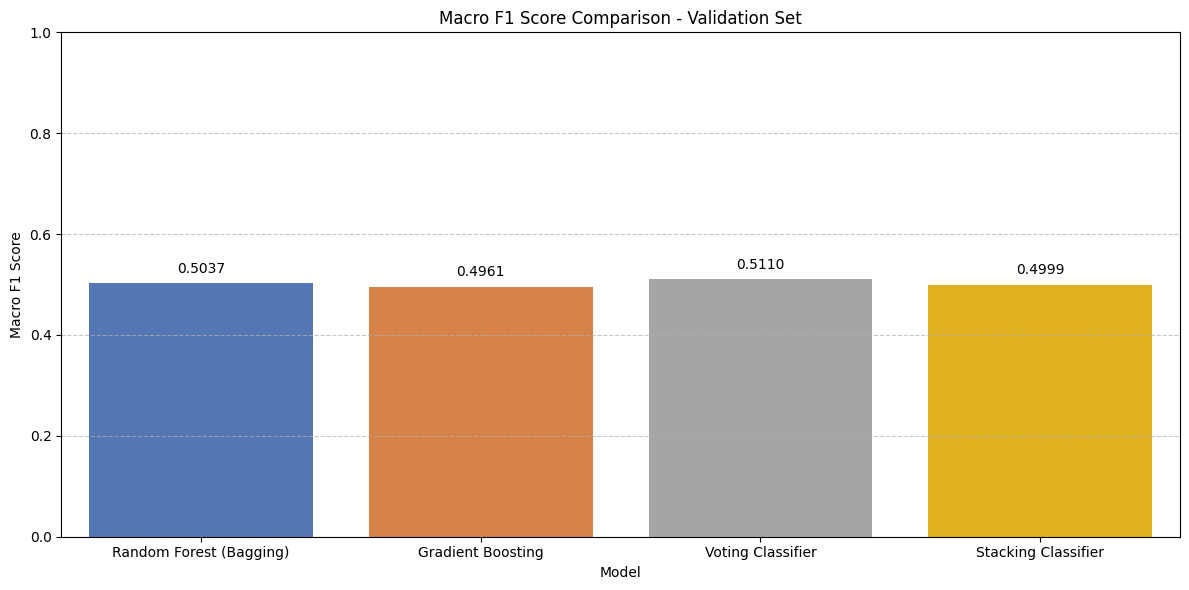

Best performing model: Voting Classifier with macro F1 score of 0.5110


In [548]:
models = {
    'Random Forest (Bagging)': rf_f1_macro,
    'Gradient Boosting': xgb_f1_macro,
    'Voting Classifier': voting_f1_macro,
    'Stacking Classifier': stacking_f1_macro
}

# Plot comparison
plt.figure(figsize=(12, 6))
model_names = list(models.keys())
model_scores = list(models.values())
colors = ['#4472C4', '#ED7D31', '#A5A5A5', '#FFC000']
sns.barplot(x=model_names, y=model_scores, palette=colors)
plt.title('Macro F1 Score Comparison - Validation Set')
plt.xlabel('Model')
plt.ylabel('Macro F1 Score')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

for i, score in enumerate(model_scores):
    plt.text(i, score + 0.02, f"{score:.4f}", ha='center')

plt.show()

# Find the best model
best_model_name = max(models, key=models.get)
best_score = models[best_model_name]
print(f"Best performing model: {best_model_name} with macro F1 score of {best_score:.4f}")


## Submission
To predict the test set target feature and submit the results to the kaggle competition platform, do the following:
1. Create a new pipeline instance identical to the first in Data Preprocessing
2. With the pipeline, apply `fit_transform` to the original training set before splitting, then only apply `transform` to the test set.
3. Retrain the model on the preprocessed training set
4. Predict the test set
5. Make sure the submission contains the `ID`, `Segmentation` column.

In [549]:
## Submission

# Choose the best model based on validation results
# We'll assume the Stacking Classifier performed best, but you should use whichever had the highest macro F1 score
best_models = {
    'Random Forest': {'model': rf_classifier, 'score': rf_f1_macro},
    'XGBoost': {'model': xgb_classifier, 'score': xgb_f1_macro},
    'Voting Classifier': {'model': voting_clf, 'score': voting_f1_macro},
    'Stacking Classifier': {'model': stacking_clf, 'score': stacking_f1_macro}
}

# Find the best model
best_model_name = max(best_models, key=lambda k: best_models[k]['score'])
best_model = best_models[best_model_name]['model']
best_score = best_models[best_model_name]['score']

print(f"Best performing model: {best_model_name} with macro F1 score of {best_score:.4f}")

# Apply feature engineering to the test data
test_df_enhanced = add_engineered_features(test_df, profession_tiers=profession_tiers)

# Make predictions on the test dataset
test_predictions = best_model.predict(test_df_enhanced)

# Create submission dataframe
submission_df = pd.DataFrame({
    'ID': test_df['ID'],
    'Segmentation': test_predictions
})

# Export to CSV
submission_df.to_csv(f'output/submission_{best_model_name}_baru.csv', index=False)
print("Submission file created successfully.")

# # Also save the best model for future use
# import joblib
# joblib.dump(best_model, f'best_model_{best_model_name.replace(" ", "_").lower()}.pkl')
# print(f"Best model ({best_model_name}) saved to disk.")

# Print summary of model and submission
print("\nSubmission Summary:")
print(f"- Selected model: {best_model_name}")
print(f"- Validation macro F1 score: {best_score:.4f}")
print(f"- Number of test records: {len(test_predictions)}")
print(f"- Segment distribution in predictions:")
for segment, count in pd.Series(test_predictions).value_counts().sort_index().items():
    print(f"  Segment {segment}: {count} ({count/len(test_predictions)*100:.2f}%)")

Best performing model: Voting Classifier with macro F1 score of 0.5110
Submission file created successfully.

Submission Summary:
- Selected model: Voting Classifier
- Validation macro F1 score: 0.5110
- Number of test records: 2421
- Segment distribution in predictions:
  Segment A: 629 (25.98%)
  Segment B: 432 (17.84%)
  Segment C: 574 (23.71%)
  Segment D: 786 (32.47%)


# 5. Error Analysis

Based on all the process you have done until the modeling and evaluation step, write an analysis to support each steps you have taken to solve this problem. Write the analysis using the markdown block. Some questions that may help you in writing the analysis:

1. Which segments (A, B, C, D) have the highest and lowest misclassification rates?
2. Are there any specific segments where the model struggles to make correct predictions?
3. Which features contribute the most to incorrect predictions?
4. Which ensemble technique (Bagging, Boosting, Stacking, Voting) produces the lowest log loss?
5. Are there significant differences in error distribution between different ensemble models?
6. Does a particular model consistently misclassify certain segments more than others?
7. etc..

`Provide your analysis here`